In [27]:
import numpy as np
import matplotlib.pyplot as plt
import time

### 学习器类定义

In [28]:
class BTree():
    def __init__(self):
        self.feature = -1
        self.split_or_weight = 0.
        self.lchild = None
        self.rchild = None

class XGBoost():
    def __init__(self): # 初始化回归树
        self.trees = []
        self.features = 0
        self.lam = 0.
        self.gamma = 0.
        self.gain_tol = 0.
        self.max_depth = 0
        self.min_num = 0

    def _choose_split_point(self, feature, g, G): # 获取最佳的划分点
        H = float(2 * g.size)
        root_score = G**2 / (H + self.lam)
        Gl = 0.
        Gr = G
        Hl = 0.
        Hr = H
        max_score = 2 * self.gamma
        split_best = 0.
        for i in range(feature.size - 1):
            Gl += g[i]
            Gr -= g[i]
            Hl += 2
            Hr -= 2
            if feature[i] == feature[i+1]:
                continue
            score = Gl**2 / (Hl + self.lam) + Gr**2 / (Hr + self.lam) - root_score
            if score > max_score:
                max_score = score
                split_best = (feature[i] + feature[i+1]) / 2
        return split_best, max_score / 2 - self.gamma

    def _get_best_split(self, X, g): # 获得最佳feature和split
        G = np.sum(g)
        max_best = 0.
        split_best = 0.
        feature = -1
        for i in range(self.features):
            seq = np.argsort(X.T[i])
            f = X.T[i][seq]
            split, max_gain = self._choose_split_point(f, g[seq], G)
            if (max_gain > max_best):
                feature = i
                split_best = split
                max_best = max_gain
        return feature, split_best, max_best
    
    def _fit_node(self, X, g, depth): #训练一棵回归树
        node = BTree()
        num = np.size(X, 0)
        feature, split, max_gain = self._get_best_split(X, g)
        if max_gain < self.gain_tol or depth >= self.max_depth or num <= self.min_num:
            node.split_or_weight = - np.sum(g) / (num * 2 + self.lam)
        else:
            l = []
            r = []
            for i in range(num):
                if X[i][feature] <= split:
                    l.append(i)
                else:
                    r.append(i)
            node.feature, node.split_or_weight = feature, split
            node.lchild = self._fit_node(X[l], g[l], depth+1)
            node.rchild = self._fit_node(X[r], g[r], depth+1)
        return node

    def fit(self, X, y, lam = 150, gamma = 1e-7, tol = 1e-7, max_trees = 20, gain_tol = 1e-7, max_depth = 10, min_num = 20): #训练
        self.lam = lam
        self.gamma = gamma
        self.gain_tol = gain_tol
        self.max_depth = max_depth
        self.min_num = min_num
        self.features = X[0].size
        losscurve = []
        loss = 0
        gdiv2 = -y
        while True:
            self.trees.append(self._fit_node(X, 2 * gdiv2, 0))
            gdiv2 = self.predict(X) - y
            preloss = loss
            loss = np.sqrt(np.sum(gdiv2 ** 2) / y.size)
            losscurve.append(loss)
            if abs(preloss - loss) < tol or max_trees <= 0:
                return losscurve
            max_trees -= 1

    def predict(self, X): # 预测多条样本
        num = np.size(X, 0)
        res = np.zeros(num)
        for i in range(num):
            x = X[i]
            for tree in self.trees:
                now = tree
                while now.lchild != None:
                    if x[now.feature] <= now.split_or_weight:
                        now = now.lchild
                    else: 
                        now = now.rchild
                res[i] += now.split_or_weight
        return res

    def _print_tree(self, tree, depth):
        if (tree.lchild != None):
            print(tree.feature)
            s = ""
            for _ in range(depth): s += "-"
            print(s, end="")
            self._print_tree(tree.lchild, depth+1)
            print(s, end="")
            self._print_tree(tree.rchild, depth+1)
        else:
            print("leaf")

    def print_out(self):
        for tree in self.trees:
            print("")
            self._print_tree(tree, 1)
            

### 读取文件

In [29]:
file = np.loadtxt("./train.data", delimiter=",")
X = file[:,0:40]
y = file[:,40]
size = y.size
t = (int)(7 * size / 10)

### 多次划分、训练、测试

time: 6.459427	RMSE: 0.000189	R^2: 0.743743
time: 6.356125	RMSE: 0.000179	R^2: 0.773068
time: 6.429375	RMSE: 0.000196	R^2: 0.751585
time: 7.680957	RMSE: 0.000190	R^2: 0.751127
time: 6.561249	RMSE: 0.000193	R^2: 0.734307


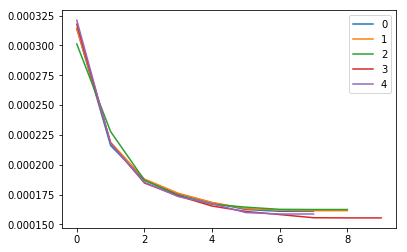

In [30]:

for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

#### 对比停止策略

time: 3.292594	RMSE: 0.000198	R^2: 0.725463
time: 3.240092	RMSE: 0.000197	R^2: 0.727989
time: 3.042747	RMSE: 0.000194	R^2: 0.740269
time: 3.027062	RMSE: 0.000193	R^2: 0.729437
time: 3.642316	RMSE: 0.000194	R^2: 0.732935


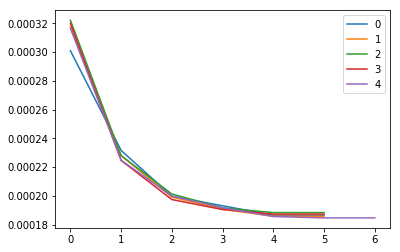

In [31]:
# Gain Tolerance停止 1e-6
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, gain_tol = 1e-6, max_depth = 1000, min_num = 0, max_trees=100)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

time: 7.510025	RMSE: 0.000184	R^2: 0.760035
time: 6.990504	RMSE: 0.000179	R^2: 0.780509
time: 7.571447	RMSE: 0.000184	R^2: 0.762102
time: 7.307167	RMSE: 0.000189	R^2: 0.758269
time: 7.256948	RMSE: 0.000181	R^2: 0.777413


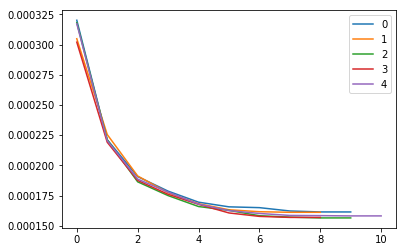

In [32]:
# Gain Tolerance停止 1e-7
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, gain_tol = 1e-7, max_depth = 1000, min_num = 0, max_trees=100)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

time: 14.029444	RMSE: 0.000185	R^2: 0.770524
time: 9.611740	RMSE: 0.000178	R^2: 0.783221
time: 9.894622	RMSE: 0.000180	R^2: 0.788756
time: 8.744988	RMSE: 0.000189	R^2: 0.763844
time: 8.890138	RMSE: 0.000190	R^2: 0.755031


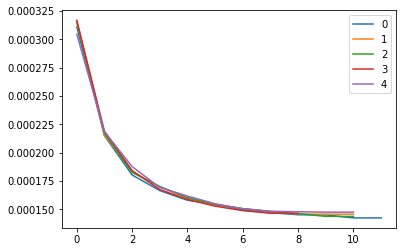

In [49]:
# Gain Tolerance停止 1e-8
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, gain_tol = 1e-8, max_depth = 1000, min_num = 0, max_trees=100)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

time: 15.929122	RMSE: 0.000186	R^2: 0.773145
time: 14.325372	RMSE: 0.000188	R^2: 0.772387
time: 14.231038	RMSE: 0.000180	R^2: 0.779865
time: 13.338531	RMSE: 0.000183	R^2: 0.775292
time: 14.347965	RMSE: 0.000187	R^2: 0.767182


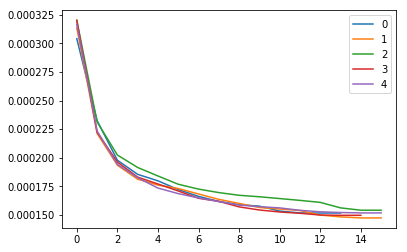

In [50]:
# Depth停止 5
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, gain_tol = 0, max_depth = 5, min_num = 0, max_trees=100)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

time: 14.149129	RMSE: 0.000195	R^2: 0.743379
time: 14.115236	RMSE: 0.000176	R^2: 0.794388
time: 14.262258	RMSE: 0.000179	R^2: 0.791457
time: 14.194366	RMSE: 0.000182	R^2: 0.779608
time: 14.222453	RMSE: 0.000184	R^2: 0.783711


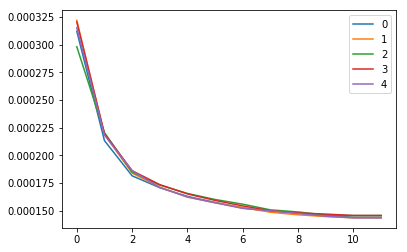

In [35]:
# Depth停止 7
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, gain_tol = 0, max_depth = 7, min_num = 0, max_trees=100)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

time: 18.141657	RMSE: 0.000186	R^2: 0.757152
time: 20.004367	RMSE: 0.000181	R^2: 0.779544
time: 18.155497	RMSE: 0.000184	R^2: 0.760115
time: 18.093467	RMSE: 0.000186	R^2: 0.769318
time: 18.175503	RMSE: 0.000190	R^2: 0.761700


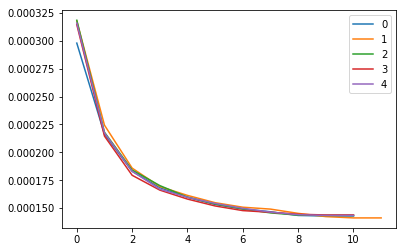

In [36]:
# Depth停止 10
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, gain_tol = 0, max_depth = 10, min_num = 0, max_trees=100)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

time: 25.613307	RMSE: 0.000186	R^2: 0.759041
time: 18.885075	RMSE: 0.000178	R^2: 0.770827
time: 18.635339	RMSE: 0.000182	R^2: 0.777347
time: 22.177774	RMSE: 0.000188	R^2: 0.762624
time: 17.484028	RMSE: 0.000187	R^2: 0.770287


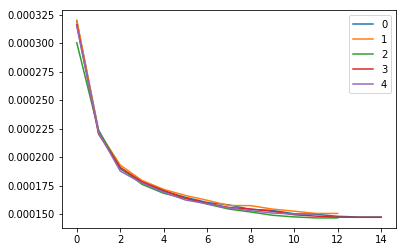

In [48]:
# Num停止 200 [depth控制]
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, gain_tol = 0, max_depth = 10, min_num = 200, max_trees=100)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

time: 16.480675	RMSE: 0.000182	R^2: 0.782463
time: 17.548392	RMSE: 0.000183	R^2: 0.772571
time: 19.272509	RMSE: 0.000188	R^2: 0.764878
time: 17.766469	RMSE: 0.000188	R^2: 0.760854
time: 19.254301	RMSE: 0.000184	R^2: 0.776410


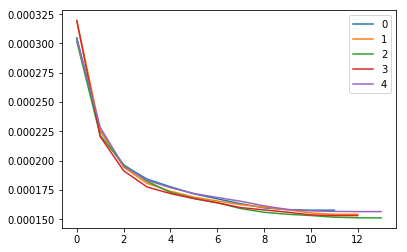

In [38]:
# Num停止 300 [depth控制]
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, gain_tol = 0, max_depth = 10, min_num = 300, max_trees=100)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

time: 27.905335	RMSE: 0.000177	R^2: 0.791918
time: 21.785236	RMSE: 0.000175	R^2: 0.789109
time: 22.431397	RMSE: 0.000182	R^2: 0.771491
time: 19.950066	RMSE: 0.000189	R^2: 0.753323
time: 20.020879	RMSE: 0.000181	R^2: 0.786448


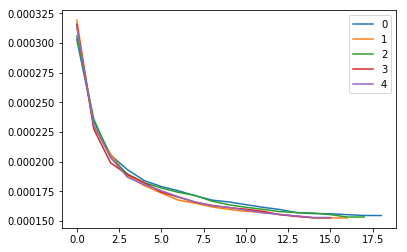

In [47]:
# Num停止 500 [depth控制]
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, gain_tol = 0, max_depth = 10, min_num = 500, max_trees=100)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

#### 对比参数

time: 5.638634	RMSE: 0.000200	R^2: 0.727461
time: 5.625928	RMSE: 0.000190	R^2: 0.755024
time: 6.176008	RMSE: 0.000195	R^2: 0.729971
time: 6.306161	RMSE: 0.000182	R^2: 0.762923
time: 4.867116	RMSE: 0.000189	R^2: 0.763827


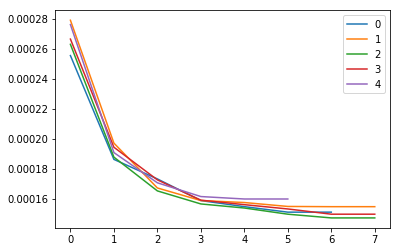

In [40]:
# lambda 50
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, lam = 50)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

time: 6.150542	RMSE: 0.000190	R^2: 0.761867
time: 6.311674	RMSE: 0.000179	R^2: 0.772808
time: 6.557066	RMSE: 0.000181	R^2: 0.787856
time: 6.051838	RMSE: 0.000185	R^2: 0.791660
time: 6.720576	RMSE: 0.000184	R^2: 0.776801


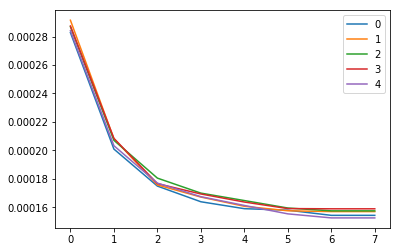

In [41]:
# lambda 100
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, lam = 100)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

time: 8.463169	RMSE: 0.000179	R^2: 0.774443
time: 7.443863	RMSE: 0.000185	R^2: 0.769423
time: 7.936302	RMSE: 0.000177	R^2: 0.791991
time: 7.473455	RMSE: 0.000187	R^2: 0.752383
time: 8.307697	RMSE: 0.000180	R^2: 0.780627


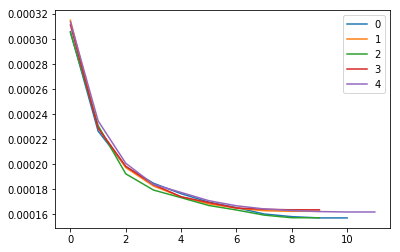

In [42]:
# lambda 200
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, lam = 200)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

time: 1.985269	RMSE: 0.000227	R^2: 0.570675
time: 1.423339	RMSE: 0.000237	R^2: 0.564372
time: 2.031640	RMSE: 0.000216	R^2: 0.629295
time: 1.601610	RMSE: 0.000244	R^2: 0.552321
time: 1.749866	RMSE: 0.000232	R^2: 0.483220


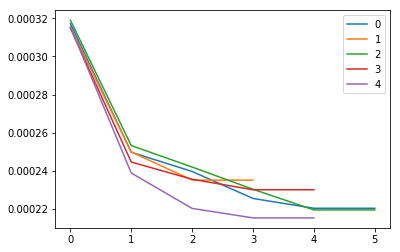

In [43]:
# gamma 1e-5
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, gamma=1e-5)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

time: 3.465952	RMSE: 0.000193	R^2: 0.735907
time: 3.790416	RMSE: 0.000196	R^2: 0.738159
time: 3.466818	RMSE: 0.000194	R^2: 0.737915
time: 4.018932	RMSE: 0.000197	R^2: 0.737499
time: 3.750370	RMSE: 0.000189	R^2: 0.745638


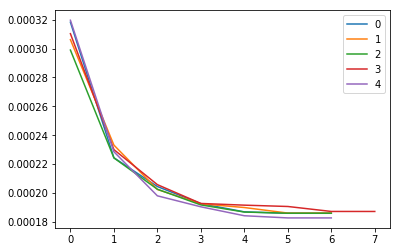

In [44]:
# gamma 1e-6
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, gamma=1e-6)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()

time: 10.003456	RMSE: 0.000182	R^2: 0.783629
time: 10.616019	RMSE: 0.000185	R^2: 0.765934
time: 11.381025	RMSE: 0.000183	R^2: 0.790084
time: 9.446692	RMSE: 0.000188	R^2: 0.759507
time: 10.132907	RMSE: 0.000185	R^2: 0.761639


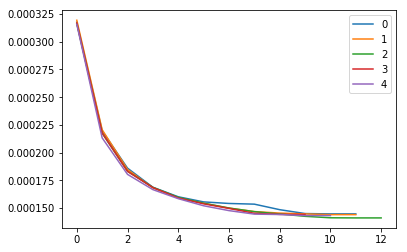

In [46]:
# gamma 0
for i in range(5):
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:t,:]
    X_test = X[t:size,:]
    y_train = y[0:t]
    y_test = y[t:size]
    boosttree = XGBoost()
    t1 = time.perf_counter()
    losscurve = boosttree.fit(X_train, y_train, gamma=0)
    t2 = time.perf_counter()
    print("time: {:.6f}".format(t2 - t1), end="\t")
    yp = boosttree.predict(X_test)
    rmse = np.sqrt(np.sum((yp-y_test) ** 2) / y_test.size)
    print("RMSE: {:.6f}".format(rmse), end="\t")
    r2 = 1 - np.sum((yp-y_test)**2) / np.sum((yp-np.average(y_test))**2)
    print("R^2: {:.6f}".format(r2))
    plt.plot(losscurve, label = str(i))
plt.legend()